In [4]:
# %% [markdown]
# # Confidence Prediction Project
# Machine Learning Project to predict confidence based on clothing color and other factors

# %% [markdown]
# ## 1. Prepare Problem

# %%
# a) Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, classification_report, 
                            confusion_matrix, roc_auc_score)
import pickle
import warnings
warnings.filterwarnings('ignore')

In [5]:
# %%
# b) Load dataset
df = pd.read_csv('Sheet 2-Table 1.csv', sep=';')
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (100, 6)


,Color of the clothes,Confident,1-10,Age,Sex,Things for a day
0,White,Yes,10,20,Female,Work
1,Black,Yes,10,21,Female,Dates
2,"Black, White",Yes,5,22,Female,"Work, study"
3,"Black, White",No,3,19,Female,Study
4,Black,Yes,10,24,Male,Not much


In [6]:
# %% [markdown]
# ## 2. Summarize Data

# %%
# a) Descriptive statistics
print("\nData types and missing values:")
print(df.info())

print("\nDescriptive statistics:")
print(df.describe())

print("\nConfident distribution:")
print(df['Confident'].value_counts(normalize=True))



Data types and missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Color of the clothes  100 non-null    object
 1   Confident             100 non-null    object
 2   1-10                  100 non-null    int64 
 3   Age                   100 non-null    int64 
 4   Sex                   100 non-null    object
 5   Things for a day      100 non-null    object
dtypes: int64(2), object(4)
memory usage: 4.8+ KB
None

Descriptive statistics:
             1-10         Age
count  100.000000  100.000000
mean     7.050000   23.670000
std      2.375698    4.815914
min      1.000000   18.000000
25%      6.000000   20.000000
50%      7.000000   23.000000
75%      9.000000   26.000000
max     10.000000   41.000000

Confident distribution:
Confident
Yes    0.81
No     0.19
Name: proportion, dtype: float64


Text(0.5, 1.0, 'Age Distribution')

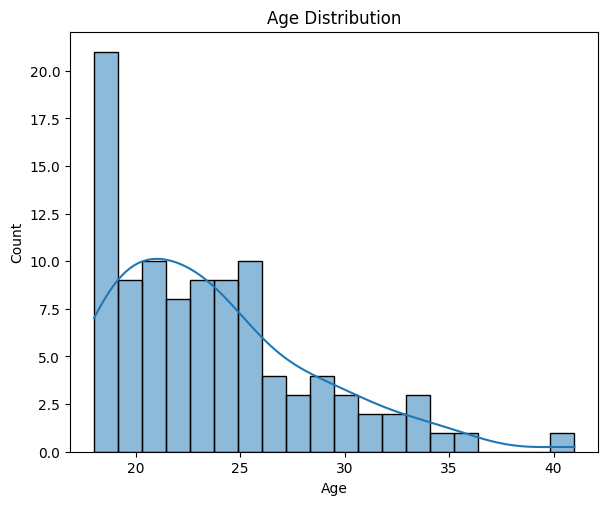

In [7]:

# %%
# b) Data visualizations
plt.figure(figsize=(15, 12))

# Age distribution
plt.subplot(2, 2, 1)
sns.histplot(df['Age'], bins=20, kde=True)
plt.title('Age Distribution')


Text(0.5, 1.0, 'Confidence Score Distribution')

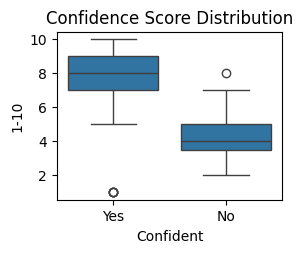

In [8]:
# Confidence score distribution
plt.subplot(2, 2, 2)
sns.boxplot(x='Confident', y='1-10', data=df)
plt.title('Confidence Score Distribution')


Text(0.5, 1.0, 'Confidence by Gender')

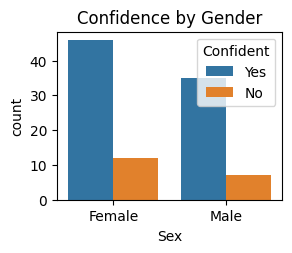

In [9]:
# Confidence by Gender
plt.subplot(2, 2, 3)
sns.countplot(x='Sex', hue='Confident', data=df)
plt.title('Confidence by Gender')


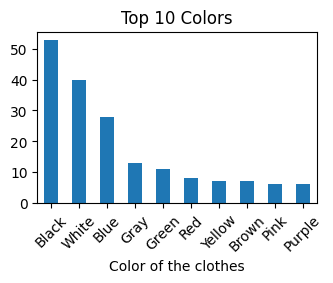

In [10]:

# Top colors
plt.subplot(2, 2, 4)
colors = df['Color of the clothes'].str.split(', ').explode()
colors.value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Colors')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [11]:
# %% [markdown]
# ## 3. Prepare Data

# %%
# a) Data Cleaning
# Extract primary color
df['Primary_Color'] = df['Color of the clothes'].str.split(',').str[0].str.strip()


In [12]:
# Clean activities
df['Things for a day'] = df['Things for a day'].str.lower()

In [13]:
# Convert target
df['Confident'] = df['Confident'].map({'Yes': 1, 'No': 0})

df.head()


,Color of the clothes,Confident,1-10,Age,Sex,Things for a day,Primary_Color
0,White,1,10,20,Female,work,White
1,Black,1,10,21,Female,dates,Black
2,"Black, White",1,5,22,Female,"work, study",Black
3,"Black, White",0,3,19,Female,study,Black
4,Black,1,10,24,Male,not much,Black


In [14]:
# %%
# b) Feature Selection
features = ['Primary_Color', '1-10', 'Age', 'Sex', 'Things for a day']
X = df[features]
y = df['Confident']

In [15]:
# c) Data Transforms
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)


Training set size: (80, 5)
Test set size: (20, 5)


In [16]:
# %% [markdown]
# ## 4. Evaluate Algorithms

# %%
# Preprocessing pipeline
categorical_features = ['Primary_Color', 'Sex', 'Things for a day']
numeric_features = ['1-10', 'Age']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [17]:
# %%
# Test options and evaluation
models = [
    ('LR', LogisticRegression(max_iter=1000)),
    ('KNN', KNeighborsClassifier()),
    ('DT', DecisionTreeClassifier(random_state=42)),
    ('SVM', SVC(probability=True)),
    ('RF', RandomForestClassifier(random_state=42)),
    ('GB', GradientBoostingClassifier(random_state=42))
]

results = []
for name, model in models:
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    cv_results = cross_val_score(pipeline, X_train, y_train, 
                               cv=5, scoring='accuracy')
    results.append((name, cv_results.mean(), cv_results.std()))
    print(f"{name}: {cv_results.mean():.3f} (±{cv_results.std():.3f})")


LR: 0.825 (±0.047)
KNN: 0.875 (±0.040)
DT: 0.850 (±0.050)
SVM: 0.812 (±0.056)
RF: 0.875 (±0.000)
GB: 0.900 (±0.050)



Model Comparison:
  Model  Mean Accuracy       Std
5    GB         0.9000  0.050000
1   KNN         0.8750  0.039528
4    RF         0.8750  0.000000
2    DT         0.8500  0.050000
0    LR         0.8250  0.046771
3   SVM         0.8125  0.055902


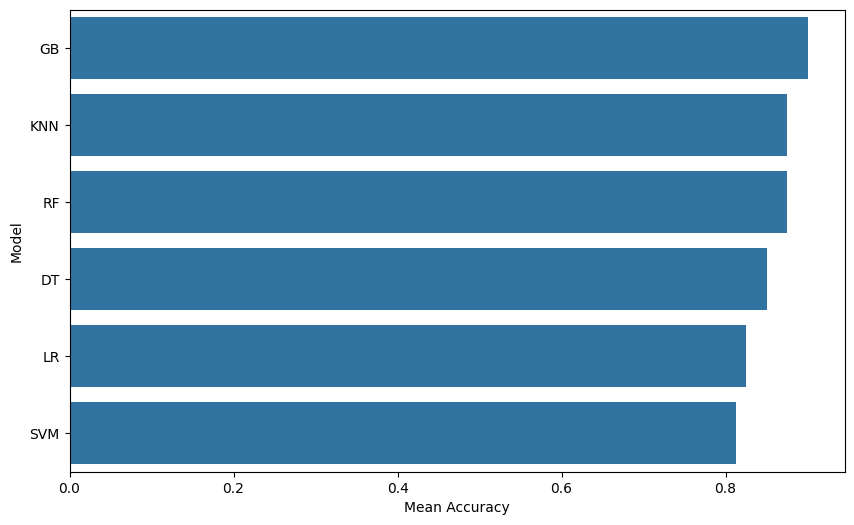

In [18]:
# %%
# Compare Algorithms - FIXED VERSION
results_df = pd.DataFrame(results, columns=['Model', 'Mean Accuracy', 'Std'])
results_df.sort_values('Mean Accuracy', ascending=False, inplace=True)
print("\nModel Comparison:")
print(results_df)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Mean Accuracy', y='Model', data=results_df)


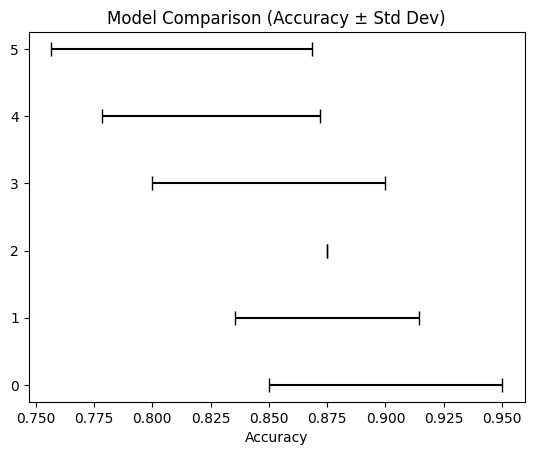

In [19]:
# Add error bars manually
for i, (_, row) in enumerate(results_df.iterrows()):
    plt.errorbar(
        x=row['Mean Accuracy'], 
        y=i,
        xerr=row['Std'],
        fmt='none', 
        color='black',
        capsize=5
    )

plt.title('Model Comparison (Accuracy ± Std Dev)')
plt.xlabel('Accuracy')
plt.show()


In [20]:
# %% [markdown]
# ## 5. Improve Accuracy

# %%
# Algorithm Tuning
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10],
    'classifier__min_samples_split': [2, 5]
}

best_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

grid_search = GridSearchCV(best_model, param_grid, cv=5, 
                          scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("\nBest parameters:", grid_search.best_params_)
print("Best CV accuracy: {:.3f}".format(grid_search.best_score_))



Best parameters: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Best CV accuracy: 0.875


In [21]:
# %%
# Evaluate on test set
best_pipeline = grid_search.best_estimator_
y_pred = best_pipeline.predict(X_test)
y_proba = best_pipeline.predict_proba(X_test)[:, 1]

print("\nTest Accuracy: {:.3f}".format(accuracy_score(y_test, y_pred)))
print("ROC AUC: {:.3f}".format(roc_auc_score(y_test, y_proba)))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Test Accuracy: 0.900
ROC AUC: 0.969

Confusion Matrix:
[[ 2  2]
 [ 0 16]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           1       0.89      1.00      0.94        16

    accuracy                           0.90        20
   macro avg       0.94      0.75      0.80        20
weighted avg       0.91      0.90      0.89        20



In [23]:
# %% [markdown]
# ## 6. Finalize Model

# %%
# Train on full data
final_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=grid_search.best_params_['classifier__n_estimators'],
        max_depth=grid_search.best_params_['classifier__max_depth'],
        min_samples_split=grid_search.best_params_['classifier__min_samples_split'],
        random_state=42))
])
final_model.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['1-10', 'Age']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Primary_Color', 'Sex',
                                                   'Things for a day'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [24]:
# %%
# Save model
model_data = {
    'model': final_model,
    'features': features,
    'target': 'Confident'
}

with open('confidence_predictor.pkl', 'wb') as f:
    pickle.dump(model_data, f)

print("Model saved as 'confidence_predictor.pkl'")


Model saved as 'confidence_predictor.pkl'


In [25]:
# %%
# Prediction function
def predict_confidence(color, score, age, sex, activities):
    input_data = pd.DataFrame({
        'Primary_Color': [color.strip()],
        '1-10': [score],
        'Age': [age],
        'Sex': [sex.strip()],
        'Things for a day': [activities.lower().strip()]
    })
    
    prediction = final_model.predict(input_data)
    probability = final_model.predict_proba(input_data)[0][1]
    
    return 'Confident' if prediction[0] == 1 else 'Not Confident', probability

In [26]:
# Example usage
example = predict_confidence('Black', 8, 25, 'Male', 'Work meeting')
print(f"\nExample Prediction: {example[0]} (Probability: {example[1]:.2f})")


Example Prediction: Confident (Probability: 1.00)
